In [2]:
import pandas as pd
import ast
import sklearn
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report, flat_f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

print("Libraries imported")

Libraries imported


In [3]:
# Chemins
# Liste des chemins des fichiers CSV
dataset_paths = [
    "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/token_classification/dataset_token_classification_1.csv",
    "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/token_classification/dataset_token_classification_1.csv",
    "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/token_classification/dataset_token_classification_1.csv",
    "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/token_classification/dataset_token_classification_1.csv"
]

model_path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/models/crf2.0/"

# Chargement des données
print("Loading datasets...")
def load_and_combine_datasets(paths):
    datasets = []
    for path in tqdm(paths, desc="Loading datasets"):
        dataset = pd.read_csv(path, delimiter=';', quotechar='"', names=["text", "tokens", "ner_tags", "spacy_ner_tags"])
        datasets.append(dataset)
    combined_dataset = pd.concat(datasets, ignore_index=True)
    return combined_dataset

dataset = load_and_combine_datasets(dataset_paths)

# Limiter à 80 000 lignes
# dataset = dataset.head(80000)

Loading datasets...


Loading datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Loading datasets: 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


In [4]:
# Prétraitement des données
def safe_eval(val):
    try:
        val = val.replace('""', '"').replace("'", '"')
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None


def prepare_data(dataset):
    sequences = []
    for _, row in tqdm(dataset.iterrows(), total=len(dataset)):
        tokens = safe_eval(row["tokens"])
        spacy_ner_tags = safe_eval(row["spacy_ner_tags"]) if pd.notnull(row["spacy_ner_tags"]) else None
        if tokens is None:
            continue
        labels = ["O"] * len(tokens)
        if spacy_ner_tags:
            for tag in spacy_ner_tags:
                start, end, label = tag['start'], tag['end'], tag['label']
                for i, token in enumerate(tokens):
                    if start <= sum(len(t) + 1 for t in tokens[:i]) < end:
                        labels[i] = label
        sequences.append((tokens, labels))
    return sequences

print("Preparing data...")
data = prepare_data(dataset)

Preparing data...


100%|██████████| 80000/80000 [01:06<00:00, 1196.28it/s]


In [5]:
# Caractéristiques pour CRF
def word2features(sent, i):
    word = sent[i]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'BOS': i == 0,
        'EOS': i == len(sent) - 1
    }
    if i > 0:
        word1 = sent[i - 1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        word1 = sent[i + 1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(labels):
    return labels

# Séparation des données
print("Splitting data...")
train, test_valid = train_test_split(data, test_size=0.5, random_state=42)
test, valid = train_test_split(test_valid, test_size=0.5, random_state=42)

X_train = [sent2features(s[0]) for s in train]
y_train = [sent2labels(s[1]) for s in train]
X_valid = [sent2features(s[0]) for s in valid]
y_valid = [sent2labels(s[1]) for s in valid]
X_test = [sent2features(s[0]) for s in test]
y_test = [sent2labels(s[1]) for s in test]

Splitting data...


In [6]:
# Entraînement du modèle CRF
print("Training CRF model...")
crf = CRF(algorithm='lbfgs', max_iterations=100, c1=0.1, c2=0.1, all_possible_transitions=True)

losses = []
for epoch in tqdm(range(20), desc="Training epochs"):
    crf.fit(X_train, y_train)
    y_pred = crf.predict(X_valid)
    f1 = flat_f1_score(y_valid, y_pred, average='weighted')
    print(f"Epoch {epoch + 1}: F1-Score on validation set: {f1:.4f}")
    losses.append(1 - f1)

Training CRF model...


Training epochs:   5%|▌         | 1/20 [00:57<18:18, 57.81s/it]

Epoch 1: F1-Score on validation set: 0.9846


Training epochs:  10%|█         | 2/20 [02:03<18:39, 62.19s/it]

Epoch 2: F1-Score on validation set: 0.9846


Training epochs:  15%|█▌        | 3/20 [03:06<17:47, 62.81s/it]

Epoch 3: F1-Score on validation set: 0.9846


Training epochs:  20%|██        | 4/20 [04:27<18:41, 70.07s/it]

Epoch 4: F1-Score on validation set: 0.9846


Training epochs:  25%|██▌       | 5/20 [05:44<18:09, 72.61s/it]

Epoch 5: F1-Score on validation set: 0.9846


Training epochs:  30%|███       | 6/20 [06:54<16:41, 71.54s/it]

Epoch 6: F1-Score on validation set: 0.9846


Training epochs:  35%|███▌      | 7/20 [07:52<14:33, 67.18s/it]

Epoch 7: F1-Score on validation set: 0.9846


Training epochs:  40%|████      | 8/20 [08:44<12:28, 62.39s/it]

Epoch 8: F1-Score on validation set: 0.9846


Training epochs:  45%|████▌     | 9/20 [09:44<11:16, 61.49s/it]

Epoch 9: F1-Score on validation set: 0.9846


Training epochs:  50%|█████     | 10/20 [10:42<10:03, 60.39s/it]

Epoch 10: F1-Score on validation set: 0.9846


Training epochs:  55%|█████▌    | 11/20 [11:39<08:55, 59.54s/it]

Epoch 11: F1-Score on validation set: 0.9846


Training epochs:  60%|██████    | 12/20 [12:36<07:48, 58.60s/it]

Epoch 12: F1-Score on validation set: 0.9846


Training epochs:  65%|██████▌   | 13/20 [13:33<06:46, 58.09s/it]

Epoch 13: F1-Score on validation set: 0.9846


Training epochs:  70%|███████   | 14/20 [14:36<05:57, 59.61s/it]

Epoch 14: F1-Score on validation set: 0.9846


Training epochs:  75%|███████▌  | 15/20 [15:33<04:54, 58.90s/it]

Epoch 15: F1-Score on validation set: 0.9846


Training epochs:  80%|████████  | 16/20 [16:33<03:56, 59.20s/it]

Epoch 16: F1-Score on validation set: 0.9846


Training epochs:  85%|████████▌ | 17/20 [17:30<02:55, 58.58s/it]

Epoch 17: F1-Score on validation set: 0.9846


Training epochs:  90%|█████████ | 18/20 [18:26<01:55, 57.69s/it]

Epoch 18: F1-Score on validation set: 0.9846


Training epochs:  95%|█████████▌| 19/20 [19:21<00:56, 56.95s/it]

Epoch 19: F1-Score on validation set: 0.9846


Training epochs: 100%|██████████| 20/20 [20:21<00:00, 61.06s/it]

Epoch 20: F1-Score on validation set: 0.9846


In [ ]:
# Entraînement du modèle CRF
print("Training CRF model...")
crf = CRF(algorithm='lbfgs', max_iterations=100, c1=0.1, c2=0.1, all_possible_transitions=True)

losses = []
for epoch in tqdm(range(20), desc="Training epochs"):
    crf.fit(X_train, y_train)
    y_pred = crf.predict(X_valid)
    f1 = flat_f1_score(y_valid, y_pred, average='weighted')
    print(f"Epoch {epoch + 1}: F1-Score on validation set: {f1:.4f}")
    losses.append(1 - f1)

Training CRF model...


Training epochs:   5%|▌         | 1/20 [00:57<18:18, 57.81s/it]

Epoch 1: F1-Score on validation set: 0.9846


Training epochs:  10%|█         | 2/20 [02:03<18:39, 62.19s/it]

Epoch 2: F1-Score on validation set: 0.9846


Training epochs:  15%|█▌        | 3/20 [03:06<17:47, 62.81s/it]

Epoch 3: F1-Score on validation set: 0.9846


Training epochs:  20%|██        | 4/20 [04:27<18:41, 70.07s/it]

Epoch 4: F1-Score on validation set: 0.9846


Training epochs:  25%|██▌       | 5/20 [05:44<18:09, 72.61s/it]

Epoch 5: F1-Score on validation set: 0.9846


Training epochs:  30%|███       | 6/20 [06:54<16:41, 71.54s/it]

Epoch 6: F1-Score on validation set: 0.9846


Training epochs:  35%|███▌      | 7/20 [07:52<14:33, 67.18s/it]

Epoch 7: F1-Score on validation set: 0.9846


Training epochs:  40%|████      | 8/20 [08:44<12:28, 62.39s/it]

Epoch 8: F1-Score on validation set: 0.9846


Training epochs:  45%|████▌     | 9/20 [09:44<11:16, 61.49s/it]

Epoch 9: F1-Score on validation set: 0.9846


Training epochs:  50%|█████     | 10/20 [10:42<10:03, 60.39s/it]

Epoch 10: F1-Score on validation set: 0.9846


Training epochs:  55%|█████▌    | 11/20 [11:39<08:55, 59.54s/it]

Epoch 11: F1-Score on validation set: 0.9846


Training epochs:  60%|██████    | 12/20 [12:36<07:48, 58.60s/it]

Epoch 12: F1-Score on validation set: 0.9846


Training epochs:  65%|██████▌   | 13/20 [13:33<06:46, 58.09s/it]

Epoch 13: F1-Score on validation set: 0.9846


Training epochs:  70%|███████   | 14/20 [14:36<05:57, 59.61s/it]

Epoch 14: F1-Score on validation set: 0.9846


Training epochs:  75%|███████▌  | 15/20 [15:33<04:54, 58.90s/it]

Epoch 15: F1-Score on validation set: 0.9846


Training epochs:  80%|████████  | 16/20 [16:33<03:56, 59.20s/it]

Epoch 16: F1-Score on validation set: 0.9846


Training epochs:  85%|████████▌ | 17/20 [17:30<02:55, 58.58s/it]

Epoch 17: F1-Score on validation set: 0.9846


Training epochs:  90%|█████████ | 18/20 [18:26<01:55, 57.69s/it]

Epoch 18: F1-Score on validation set: 0.9846


Training epochs:  95%|█████████▌| 19/20 [19:21<00:56, 56.95s/it]

Epoch 19: F1-Score on validation set: 0.9846


Training epochs: 100%|██████████| 20/20 [20:21<00:00, 61.06s/it]

Epoch 20: F1-Score on validation set: 0.9846


In [7]:
# Évaluation finale
print("\nEvaluating on test set...")
y_pred = crf.predict(X_test)
report = flat_classification_report(y_test, y_pred)
print("\nClassification Report on Test Set:")
print(report)


Evaluating on test set...

Classification Report on Test Set:
              precision    recall  f1-score   support

         ARR       0.97      0.96      0.96     17933
         DEP       0.98      0.98      0.98     17953
           O       0.99      0.99      0.99     98169

    accuracy                           0.98    134055
   macro avg       0.98      0.98      0.98    134055
weighted avg       0.98      0.98      0.98    134055



Saving model...


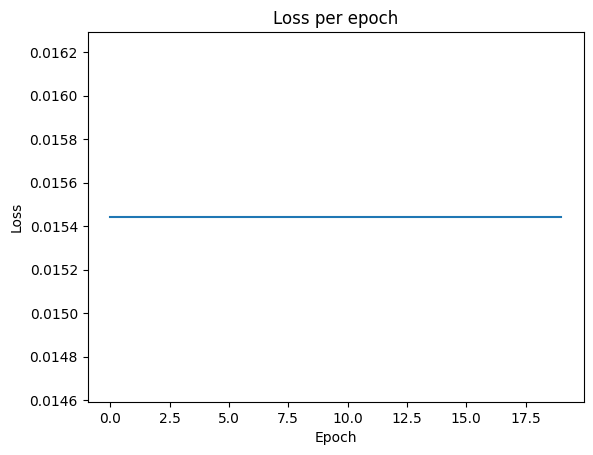


Testing on new sentences...

Phrase: Je pars de Paris et j'arrive à Marseille.
 - Je: O
 - pars: O
 - de: O
 - Paris: ARR
 - et: ARR
 - j'arrive: ARR
 - à: O
 - Marseille.: O

Phrase: Je vais à Bordeaux en partant de Toulouse.
 - Je: O
 - vais: O
 - à: O
 - Bordeaux: ARR
 - en: O
 - partant: O
 - de: O
 - Toulouse.: O

Phrase: Mon trajet va de VILLIERS SUR LOIR à JARNY.
 - Mon: O
 - trajet: O
 - va: O
 - de: O
 - VILLIERS: DEP
 - SUR: DEP
 - LOIR: DEP
 - à: O
 - JARNY.: ARR

Phrase: Nous partons de Lyon et nous arrivons à Nice.
 - Nous: O
 - partons: O
 - de: O
 - Lyon: DEP
 - et: O
 - nous: O
 - arrivons: O
 - à: O
 - Nice.: O

Phrase: Le départ est prévu à Lille, et l'arrivée se fera à Strasbourg.
 - Le: O
 - départ: O
 - est: O
 - prévu: O
 - à: O
 - Lille,: ARR
 - et: O
 - l'arrivée: O
 - se: O
 - fera: O
 - à: O
 - Strasbourg.: O

Phrase: Mon itinéraire inclut un départ de Montpellier et une arrivée à Perpignan.
 - Mon: O
 - itinéraire: O
 - inclut: O
 - un: O
 - départ: O
 - de:

In [8]:
import os
import joblib
import matplotlib.pyplot as plt

# Assurez-vous que le répertoire existe
if not os.path.exists(model_path):
    os.makedirs(model_path)

print("Saving model...")
joblib.dump(crf, model_path + "crf_model.joblib")

# Visualisation des pertes
plt.plot(losses)
plt.title("Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Test du modèle sur des phrases
test_sentences = [
    "Je pars de Paris et j'arrive à Marseille.",
    "Je vais à Bordeaux en partant de Toulouse.",
    "Mon trajet va de VILLIERS SUR LOIR à JARNY.",
    "Nous partons de Lyon et nous arrivons à Nice.",
    "Le départ est prévu à Lille, et l'arrivée se fera à Strasbourg.",
    "Mon itinéraire inclut un départ de Montpellier et une arrivée à Perpignan.",
    "Le train partira de Nantes pour arriver à Rennes.",
    "Un vol de Genève à Zurich est prévu demain matin.",
    "Je vais de Grenoble à Dijon en voiture.",
    "Je voyage de Bruxelles à Amsterdam ce week-end.",
    "L'itinéraire commence à Marseille et se termine à Toulon.",
    "Nous prenons un train de Rouen pour aller au Havre.",
    "Le départ sera à Limoges et l'arrivée à Poitiers.",
    "Je quitte Monaco pour aller à Menton.",
    "Le bus va de Caen à Cherbourg.",
    "Il part de Bayonne et arrive à Biarritz.",
    "Je vais de Chamonix à Annecy.",
    "Nous roulons de Bastia à Ajaccio.",
    "Le ferry part de Calais pour arriver à Douvres.",
    "Je pars de Bordeaux et j'arrive à Paris.",
    "Notre vol va de Madrid à Barcelone.",
    "Un trajet en voiture de Milan à Rome est prévu.",
    "Le départ est de Zurich et l'arrivée est à Lausanne.",
    "Je vais à Londres depuis Manchester.",
    "Le train va de Tokyo à Kyoto."
]

print("\nTesting on new sentences...")
for sentence in test_sentences:
    tokens = sentence.split()
    features = sent2features(tokens)
    prediction = crf.predict([features])[0]
    print(f"\nPhrase: {sentence}")
    for token, label in zip(tokens, prediction):
        print(f" - {token}: {label}")